In [9]:
!pip install numpy scipy python_speech_features scikit-learn tensorflow

In [10]:
!pip install soundfile sounddevice
!pip install pydub
!apt-get install ffmpeg

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
# import os
# os.listdir('/content/drive/My Drive/')

In [13]:
# import zipfile
# import os
# uploaded = '/content/drive/My Drive/IntoAI/data/clips.zip'

# with zipfile.ZipFile(uploaded, 'r') as zip_ref:
#     zip_ref.extractall('/content/drive/My Drive/IntoAI/data/clips2/')

# print(f"Extracted {uploaded}")

# extracted_files = os.listdir('/content/drive/My Drive/IntoAI/data/clips2/')
# print("Extracted files:", extracted_files)

In [14]:
import pandas as pd

clips_folder = '/content/drive/My Drive/IntoAI/data/clips2/clips/'
#clips_folder = '/content/drive/My Drive/IntoAI/data/clips1/'
tsv_path = '/content/drive/My Drive/IntoAI/data/train.tsv'

train_df = pd.read_csv(tsv_path, sep='\t')
train_df.head()


# print(clips_files)

,client_id,path,sentence_id,sentence,sentence_domain,up_votes,down_votes,age,gender,accents,variant,locale,segment
0,710a66896d64fa543754f00b87ecc54ed16eba3920bc13...,common_voice_zh-TW_18683232.mp3,4b3db779e5522437855d079dbb23f8d292d32ad8b4156b...,有一天離開的時候,NaN,2,0,NaN,NaN,NaN,NaN,zh-TW,NaN
1,710a66896d64fa543754f00b87ecc54ed16eba3920bc13...,common_voice_zh-TW_18683268.mp3,e666725a3aa096fcccc043c18c98880b246d60e28200c2...,所以他們今天到底有沒有約,NaN,2,0,NaN,NaN,NaN,NaN,zh-TW,NaN
2,710a66896d64fa543754f00b87ecc54ed16eba3920bc13...,common_voice_zh-TW_18683270.mp3,d79fd9db20e7624094affa917f52db393613e962414137...,還沒傳完嗎？,NaN,2,0,NaN,NaN,NaN,NaN,zh-TW,NaN
3,710a66896d64fa543754f00b87ecc54ed16eba3920bc13...,common_voice_zh-TW_18683281.mp3,2764ef00a2c51e4ba502ce33dda720af613b5f255c5e33...,不在此限,NaN,2,0,NaN,NaN,NaN,NaN,zh-TW,NaN
4,710a66896d64fa543754f00b87ecc54ed16eba3920bc13...,common_voice_zh-TW_18683282.mp3,f51bfd6084af996c21bc38799592d3e5bde5807ec04a66...,商業登記,NaN,2,0,NaN,NaN,NaN,NaN,zh-TW,NaN


In [15]:
import os
clips_files = set(os.listdir(clips_folder))

In [16]:
filtered_train_df = train_df[train_df['path'].apply(lambda x: x in clips_files)]

filtered_train_df.reset_index(drop=True, inplace=True)

filtered_train_df.head()

,client_id,path,sentence_id,sentence,sentence_domain,up_votes,down_votes,age,gender,accents,variant,locale,segment
0,710a66896d64fa543754f00b87ecc54ed16eba3920bc13...,common_voice_zh-TW_18683232.mp3,4b3db779e5522437855d079dbb23f8d292d32ad8b4156b...,有一天離開的時候,NaN,2,0,NaN,NaN,NaN,NaN,zh-TW,NaN
1,710a66896d64fa543754f00b87ecc54ed16eba3920bc13...,common_voice_zh-TW_18683268.mp3,e666725a3aa096fcccc043c18c98880b246d60e28200c2...,所以他們今天到底有沒有約,NaN,2,0,NaN,NaN,NaN,NaN,zh-TW,NaN
2,710a66896d64fa543754f00b87ecc54ed16eba3920bc13...,common_voice_zh-TW_18683270.mp3,d79fd9db20e7624094affa917f52db393613e962414137...,還沒傳完嗎？,NaN,2,0,NaN,NaN,NaN,NaN,zh-TW,NaN
3,710a66896d64fa543754f00b87ecc54ed16eba3920bc13...,common_voice_zh-TW_18683281.mp3,2764ef00a2c51e4ba502ce33dda720af613b5f255c5e33...,不在此限,NaN,2,0,NaN,NaN,NaN,NaN,zh-TW,NaN
4,710a66896d64fa543754f00b87ecc54ed16eba3920bc13...,common_voice_zh-TW_18683282.mp3,f51bfd6084af996c21bc38799592d3e5bde5807ec04a66...,商業登記,NaN,2,0,NaN,NaN,NaN,NaN,zh-TW,NaN


In [17]:
import numpy as np
import scipy.io.wavfile as wav
from python_speech_features import mfcc
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Masking
import matplotlib.pyplot as plt
import wave
from pydub import AudioSegment
import soundfile as sf


cot = 0

def extract_features(filename):

    audio = AudioSegment.from_mp3(filename)
    audio.export("temp.wav", format="wav")

    signal, samplerate = sf.read("temp.wav")
    mfcc_features = mfcc(signal, samplerate, nfft=1200)
    return mfcc_features

X = []
y = []

for index, row in filtered_train_df.iterrows():
    cot += 1

    # if cot % 6000 == 0:
    #   # np.save('/content/drive/My Drive/IntoAI/X_train.npy', X_train)
    #   # np.save('/content/drive/My Drive/IntoAI/X_test.npy', X_test)
    #   # np.save('/content/drive/My Drive/IntoAI/y_train.npy', y_train)
    #   # np.save('/content/drive/My Drive/IntoAI/y_test.npy', y_test)
    #   if cot == 12000:
    #     break

    filepath = clips_folder + row['path']
    features = extract_features(filepath)
    X.append(features)
    y.append(row['sentence'])

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_encoded = tf.keras.utils.to_categorical(y_encoded)

max_len = max([len(feature) for feature in X])
X_padded = np.array([np.pad(feature, ((0, max_len - len(feature)), (0, 0)), 'constant') for feature in X])

X_train, X_test, y_train, y_test = train_test_split(X_padded, y_encoded, test_size=0.2, random_state=42)

In [18]:
np.save('/content/drive/My Drive/IntoAI/X_train.npy', X_train)
np.save('/content/drive/My Drive/IntoAI/X_test.npy', X_test)
np.save('/content/drive/My Drive/IntoAI/y_train.npy', y_train)
np.save('/content/drive/My Drive/IntoAI/y_test.npy', y_test)

Epoch 1/20
43/43 [==============================] - 179s 4s/step - loss: 7.6894 - accuracy: 0.0000e+00 - val_loss: 7.6790 - val_accuracy: 0.0000e+00
Epoch 2/20
43/43 [==============================] - 165s 4s/step - loss: 7.4682 - accuracy: 0.0044 - val_loss: 8.4505 - val_accuracy: 0.0000e+00
Epoch 3/20
43/43 [==============================] - 152s 4s/step - loss: 6.9634 - accuracy: 0.0095 - val_loss: 9.0151 - val_accuracy: 0.0000e+00
Epoch 4/20
43/43 [==============================] - 158s 4s/step - loss: 6.5099 - accuracy: 0.0197 - val_loss: 9.7886 - val_accuracy: 0.0000e+00
Epoch 5/20
43/43 [==============================] - 162s 4s/step - loss: 6.0976 - accuracy: 0.0380 - val_loss: 10.0690 - val_accuracy: 0.0000e+00
Epoch 6/20
43/43 [==============================] - 148s 3s/step - loss: 5.7140 - accuracy: 0.0724 - val_loss: 10.4206 - val_accuracy: 0.0000e+00
Epoch 7/20
43/43 [==============================] - 164s 4s/step - loss: 5.3870 - accuracy: 0.1111 - val_loss: 10.6891 - val

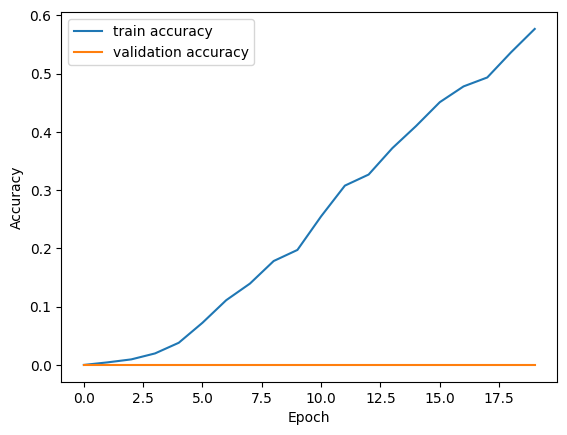

In [19]:
# LSTM model
model = Sequential()
model.add(Masking(mask_value=0.0, input_shape=(max_len, X_train.shape[2])))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(128))
model.add(Dropout(0.2))
model.add(Dense(y_train.shape[1], activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [20]:
def predict_with_lstm(filename):
    new_features = extract_features(filename)
    new_features_padded = np.pad(new_features, ((0, max_len - len(new_features)), (0, 0)), 'constant')
    new_features_padded = np.expand_dims(new_features_padded, axis=0)

    prediction = model.predict(new_features_padded)
    predicted_label = label_encoder.inverse_transform([np.argmax(prediction)])
    return predicted_label[0]

filename = '/content/drive/My Drive/IntoAI/data/clips1/common_voice_zh-TW_17367893.mp3' #from test.tsv
audio = AudioSegment.from_mp3(filename)
audio.export("temp1.wav", format="wav")
lstm_result = predict_with_lstm("temp1.wav")
print("LSTM Result:", lstm_result)

1/1 [==============================] - 4s 4s/step
LSTM Result: 應該前陣子忙著評鑑吧


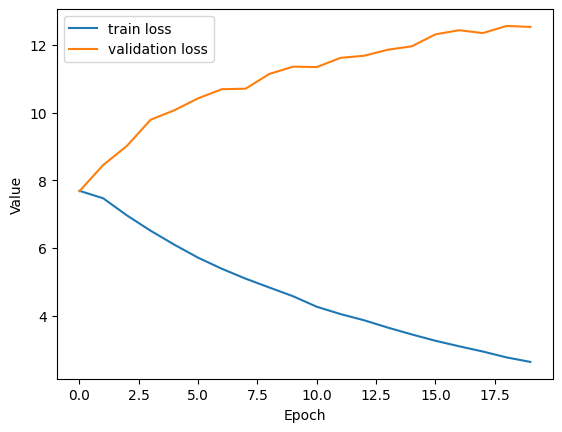

In [21]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')

plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.show()